In [1]:
import numpy as np
import networkx as nx
import osmnx as ox

# Motif Finding with Analytic Formulas

In this notebook I will try to use the approach by Estrada and Knight to count motifs in some city networks. That is, I will treat the networks as undirected graphs and count subgraphs using analytic formulae that they derived. Only non-nested motifs of $3$ and $4$ nodes will be considered.

In this notebook, let $G$ denote a simple undirected finite graph on $n$ vertices indexed from $1$ to $n$. Let $k_i$ denote the degree (i.e. the number of neighborhs) of vertex $i$. Let $A$ denote the adjacency matrix of the graph $G$. With some linear algebra and the definition of the adhacency matrix, I will use that:

$$k_x = \sum_{j=1}^n A_{xj} = \sum_{i=1}^n A_{ix}$$

## Formulas for Subgraph Counting

First, we count the total occurences of each motif. There are in total $8$ triadic and tetradic motifs, and Estrada and Knight present a way of counting each of them using the adjacency matrix of the graph. To denote the number of occurences for a motif $G$ on $n$ nodes I use $\vert M^n_G\vert$. We will consider $6$ classes of motifs:

1) The path graph, a graph in which all vertices are lined up, is denoted by $P$.

2) The complete graph, that is a graph with all possible edges, is denoted by $K$.

3) The star graph, a tree in which all but one vertex have degree one, is denoted by $S$.

4) The cycle graph, a two-regular connected graph, is denoted by $C$.

5) The diamond graph $D$ is a cycle of length $4$ with one diagonal.

6) The tadpole motifs $Td$ are formed by a closed cycle with an additional edge attached to a single vertex.

Notice that, in the case of three-node motifs, we can talk only of the complete graph and the path (which are isomorphic to the cycle and the star, respectively). In the case of four-node motifs all six are present and non-isomorphic.

We reproduce below the formulas for the counting of these motifs, and a python function that performs each calculation. Since several of these functions require the same inputs, it is important to have the following variables prior to calling the:

1) The number of vertices $n$ in the network.

2) The number of edges $m$ in the network.

3) The adjacency matrix $A$, and its second, third and fourth powers.

$$ \vert M^3_P\vert = \dfrac{1}{2}\sum_{i=1}^n k_i(k_i-1)$$

In [2]:
def count_path3(A, n):
    s = 0
    for i in range(n):
        degree = np.sum(A[i])
        s +=  degree*(degree - 1)
    count = 0.5*s
    return count

$$ \vert M^3_K\vert = \dfrac{1}{6}\text{Tr}(A^3)$$

In [3]:
def count_complete3(A_cube):
    trace = np.trace(A_cube)
    count = trace/6
    return count

$$ \vert M^4_P\vert = \sum_{\{i,j\}\in E(G)} (k_i-1)(k_j-1) - 3\vert M^3_K\vert$$

In [4]:
def count_path4(A, complete3, n):
    s = 0
    for i in range(n):
        for j in range(i, n):
            if A[i,j] != 0:
                degree_i = np.sum(A[i])
                degree_j = np.sum(A[j])
                s += (degree_i - 1)*(degree_j - 1)
    count = s - 3*complete3
    return count

$$ \vert M^4_K\vert = \dfrac{1}{24}\sum_{i=1}^n \text{Tr}(A^3_{N(i)})$$

This one is computationally hard. In fact the problem of finding complete subgraphs is, in general, NP-complete. We use the technique that Lanford and Duval also used, as they argued it gives the best runtime. We really need this quantity, as it comes up a lot of times for calculating non-nested motifs.

In [5]:
def count_complete4(graph):
    s = 0
    for i in graph.nodes:
        nb = graph[i]
        sub = graph.subgraph(nb)
        Asub = nx.to_numpy_matrix(sub)
        Asub_cube = np.linalg.matrix_power(Asub, 3)
        s += np.trace(Asub_cube)
    count = s/24
    return count

$$ \vert M^4_S\vert = \dfrac{1}{6}\sum_{i=1}^n k_i(k_i-1)(k_i -2)$$

In [6]:
def count_star4(A, n):
    s = 0
    for i in range(n):
        degree = np.sum(A[i])
        s +=  degree*(degree - 1)*(degree - 2)
    count = s/6
    return count

$$ \vert M^4_C\vert = \dfrac{1}{8}\text{Tr}(A^4) - \dfrac{1}{2}\vert M_P^3\vert - \dfrac{1}{4}m$$

In [7]:
def count_cycle4(A_fourth, path3, m):
    trace = np.trace(A_fourth)
    count = trace/8 - path3/2 - m/4
    return count

$$ \vert M^4_D\vert = \dfrac{1}{4}\sum_{i=1}^n\sum_{j=1}^n A^2_{ij}A_{ij}(A^2_{ij}A_{ij} - 1)$$

In [8]:
def count_diamond4(A, A_square, n):
    s = 0
    for i in range(n):
        for j in range(n):
            walks = A_square[i,j]*A[i,j]
            s += walks*(walks-1)
    count = s/4
    return count

$$ \vert M^4_{Td}\vert = \dfrac{1}{2}\sum_{k_i > 2} A^3_{ii}(k_i -2)$$

In [9]:
def count_tadpole4(A, A_cube, n):
    s = 0
    for i in range(n):
        degree = np.sum(A[i])
        if degree > 2:
            s += A_cube[i,i]*(degree-2)
    count = s/2
    return count

For my purposes, we should be able to input a graph and get a vector whose entries are the occurence of each of these motifs (in the order listed above).

In [26]:
def get_motifvector(graph, verbose=False):
    #First we get the quantities we will need from this graph:
    n = graph.order()
    m = graph.size()
    if verbose == True:
        print("This graph has", n, "nodes and", m, "edges.")
    A = nx.to_numpy_matrix(graph)    
    #A = nx.adjacency_matrix(graph)    #This returns a sparse matrix!
    if verbose == True:
        print("Found the adjacency matrix!")
    A_square = np.linalg.matrix_power(A, 2)
    #A_square = A.power(2)
    A_cube = np.linalg.matrix_power(A, 3)
    #A_cube = A.power(3)
    A_fourth = np.linalg.matrix_power(A, 4)
    #A_fourth = A.power(4)
    if verbose == True:
        print("Found the powers.\n")
    #Now we count occurences of the motifs:
    motifs = np.zeros(8)
    motifs[0] = count_path3(A, n)
    motifs[1] = count_complete3(A_cube)
    motifs[2] = count_path4(A, motifs[1], n)
    motifs[3] = count_complete4(graph)
    motifs[4] = count_star4(A, n)
    motifs[5] = count_cycle4(A_fourth, motifs[0], m)
    motifs[6] = count_diamond4(A, A_square, n)
    motifs[7] = count_tadpole4(A, A_cube, n)
    return motifs

Let's try these formulas in a simple network

In [11]:
G = nx.Graph()
G.add_nodes_from(list(range(8)))
G.add_edges_from([(0,1),(1,2), (2,3), (4,5), (5, 6), (6, 7), (1,5), (1,6), (2,6)])

[[0. 4. 1. 1. 1. 1. 2. 1.]
 [4. 4. 7. 1. 1. 7. 7. 2.]
 [1. 7. 2. 3. 2. 2. 7. 1.]
 [1. 1. 3. 0. 0. 2. 1. 1.]
 [1. 1. 2. 0. 0. 3. 1. 1.]
 [1. 7. 2. 2. 3. 2. 7. 1.]
 [2. 7. 7. 1. 1. 7. 4. 4.]
 [1. 2. 1. 1. 1. 1. 4. 0.]]


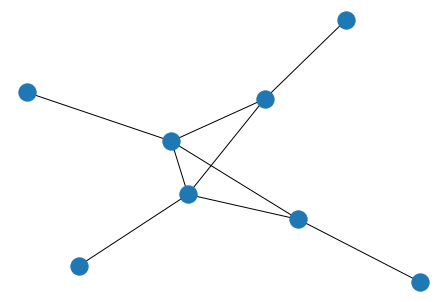

In [12]:
nx.draw(G)
#A = nx.to_numpy_matrix(G)
#A_cube = np.linalg.matrix_power(A, 3)
#print(A_cube)

We can compute by hand that this graph has 18 paths of length 3 and 2 triangles. It has 27 paths of length 4, no complete 4-graph, 10 4-stars, 1 square, 1 diamond, and 10 tadpoles. Now we check our functions:

In [13]:
test_vec = get_motifvector(G, True)
print(test_vec)

This graph has 8 nodes and 9 edges.
Found the adjacency matrix!
Found the powers.

[18.  2. 27.  0. 10.  1.  1. 10.]


### Counting Non-Nested Subgraphs

As remarked by Duval and Lawford, we only consider the non-nested subgraphs. That is, a triangle contains three paths of length $3$, and it makes no sense that we consider them if we are counting the triangle. Note that we are only thinking of motifs that are nested in motifs of the same size---so a triangle is not considered to be nested into a diamond, for example. The formula for non-nested motifs, denoted by $\vert \tilde{M}\vert$ are:

$$\vert \tilde{M}^3_P\vert = \vert M^3_P\vert - 3\vert M^3_K\vert$$

In [14]:
def nnest_path3(motifs):
    return motifs[0] - 3*motifs[1]

$$\vert \tilde{M}^4_P\vert = \vert M^4_P\vert - 2\vert M^4_{Td}\vert - 4\vert M^4_C\vert + 6\vert M^4_D\vert -12\vert M^4_K\vert$$

In [15]:
def nnest_path4(motifs):
    return motifs[2] - 2*motifs[7] - 4*motifs[5] + 6*motifs[6] - 12*motifs[3]

$$\vert \tilde{M}^4_S\vert = \vert M^4_S\vert - \vert M^4_{Td}\vert + 2\vert M^4_D\vert - 4\vert M^4_K\vert$$

In [16]:
def nnest_star4(motifs):
    return motifs[4] - motifs[7] + 2*motifs[6] - 4*motifs[3]

$$\vert \tilde{M}^4_C\vert = \vert M^4_C\vert - \vert M^4_D\vert + 3\vert M^4_K\vert$$

In [17]:
def nnest_cycle4(motifs):
    return motifs[5] - motifs[6] + 3*motifs[3]

$$\vert \tilde{M}^4_D\vert = \vert M^4_D\vert - 6\vert M^4_K\vert$$

In [18]:
def nnest_diamond4(motifs):
    return motifs[6] - 6*motifs[3]

$$\vert \tilde{M}^4_{Td}\vert = \vert M^4_{Td}\vert - 4\vert M^4_D\vert + 12\vert M^4_K\vert$$

In [19]:
def nnest_tadpole4(motifs):
    return motifs[7] - 4*motifs[6] + 12*motifs[3]

And we can form a vector of non-nested motifs

In [20]:
def get_nnest_motifvector(motifs):
    nnest_motifs = np.zeros(8)
    nnest_motifs[0] = nnest_path3(motifs)
    nnest_motifs[1] = motifs[1]
    nnest_motifs[2] = nnest_path4(motifs)
    nnest_motifs[3] = motifs[3]
    nnest_motifs[4] = nnest_star4(motifs)
    nnest_motifs[5] = nnest_cycle4(motifs)
    nnest_motifs[6] = nnest_diamond4(motifs)
    nnest_motifs[7] = nnest_tadpole4(motifs)
    return nnest_motifs

In our example network, we have:

In [21]:
nnest_test = get_nnest_motifvector(test_vec)
print(nnest_test)

[12.  2.  9.  0.  2.  0.  1.  6.]


## Finding subgraphs in Street Networks

Now that we have the formulas, we should apply them to street networks found through OSMnx

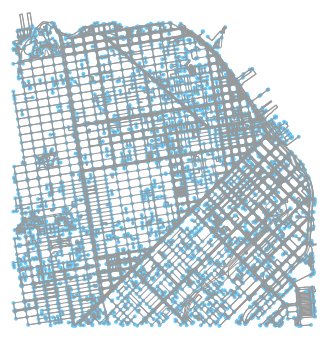

(<Figure size 528.083x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28435896608>)

In [22]:
#This is the neighborhood around the Empire State, Geoff Boeing uses it as an example so I just increased the radius
H = ox.graph_from_point((37.79, -122.41), dist=2000, network_type='all')
ox.plot_graph(H)

We need to clean up this graph to satisfy the assumptions we have made in our calculation. Parallel edges and self-loops must be removed.

In [23]:
def no_multiedge(graph):
    return nx.Graph(graph)

In [24]:
def no_selfloop(graph):
    graph.remove_edges_from(nx.selfloop_edges(graph))
    return graph

In [27]:
F = no_multiedge(H)
sl = nx.number_of_selfloops(F) #keep track of this for later on
F = no_selfloop(F)

print(get_motifvector(F, True))

This graph has 9242 nodes and 14743 edges.
Found the adjacency matrix!
Found the powers.

[3.6679e+04 3.4000e+02 9.2114e+04 0.0000e+00 2.0990e+04 3.1810e+03
 7.7000e+01 1.8090e+03]


In [28]:
print("This graph also has", sl, "self-loops.")

This graph also has 30 self-loops.


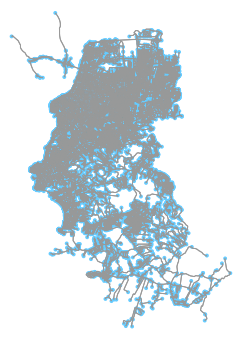

This graph has 35546 nodes and 49773 edges.


MemoryError: Unable to allocate 9.41 GiB for an array with shape (35546, 35546) and data type float64

In [29]:
H2 = ox.graph_from_place('Porto Alegre, Brazil')
ox.plot_graph(H2)

F2 = no_multiedge(H2)
sl2= nx.number_of_selfloops(F2) #keep track of this for later on
F2 = no_selfloop(F2)

print(get_motifvector(F2, True))
print("This graph also has", sl2, "self-loops.")